<a href="https://colab.research.google.com/github/fanaev/tadimo-labs/blob/main/blank_04_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import tqdm
from sklearn.metrics import classification_report

## 1. Классификация предметов одежды (датасет Fashion MNIST)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = testset.__len__(), shuffle = True, pin_memory = True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw




### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

#### Model + Trainig

In [ ]:
model = nn.Sequential(nn.Linear(28*28, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     ).to(device)

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.002)

epochs = 10

train_losses, test_losses = [], []

for e in tqdm.tqdm(range(epochs)):
  running_loss = 0
  for images, labels in trainloader:
    images = images.view(images.shape[0], -1).to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
      model.eval()
      
      for images, labels in testloader:
        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

 10%|█         | 1/10 [00:09<01:25,  9.49s/it]

Training loss: 0.597.. Test loss: 0.440.. Test Accuracy: 0.839


 20%|██        | 2/10 [00:16<01:04,  8.07s/it]

Training loss: 0.436.. Test loss: 0.400.. Test Accuracy: 0.856


 30%|███       | 3/10 [00:23<00:53,  7.65s/it]

Training loss: 0.401.. Test loss: 0.389.. Test Accuracy: 0.858


 40%|████      | 4/10 [00:31<00:47,  7.88s/it]

Training loss: 0.380.. Test loss: 0.386.. Test Accuracy: 0.861


 50%|█████     | 5/10 [00:39<00:38,  7.62s/it]

Training loss: 0.365.. Test loss: 0.369.. Test Accuracy: 0.868


 60%|██████    | 6/10 [00:46<00:29,  7.45s/it]

Training loss: 0.351.. Test loss: 0.360.. Test Accuracy: 0.872


 70%|███████   | 7/10 [00:53<00:22,  7.35s/it]

Training loss: 0.347.. Test loss: 0.356.. Test Accuracy: 0.874


 80%|████████  | 8/10 [01:00<00:14,  7.32s/it]

Training loss: 0.333.. Test loss: 0.366.. Test Accuracy: 0.869


 90%|█████████ | 9/10 [01:07<00:07,  7.26s/it]

Training loss: 0.331.. Test loss: 0.358.. Test Accuracy: 0.875


100%|██████████| 10/10 [01:14<00:00,  7.48s/it]

Training loss: 0.321.. Test loss: 0.351.. Test Accuracy: 0.879


#### Loss history

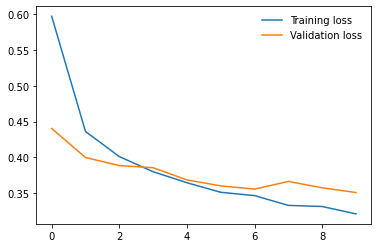

In [ ]:
plt.plot(train_losses, label = "Training loss")
plt.plot(list(map(lambda x: x.cpu(), test_losses)), label = "Validation loss")
plt.legend(frameon = False)

#### Eval + classification report

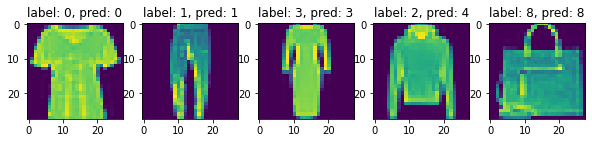

In [ ]:
fig, axs = plt.subplots(1, 5)
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(5):
  image = images[i].cpu()
  label = labels[i].cpu()
  pred = torch.argmax(torch.exp(model(images[i].view(1, 784)))).cpu()
  axs[i].imshow(image.reshape([28, 28]))
  axs[i].set_title(f'label: {label}, pred: {pred}')

In [ ]:
for images, labels in testloader:
  output = model(images.view(images.shape[0], -1).to(device))
  output = torch.argmax(torch.exp(output), dim = 1).cpu().numpy()
  labels = labels.numpy()

In [ ]:
print(classification_report(labels, output))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.99      0.96      0.97      1000
           2       0.76      0.76      0.76      1000
           3       0.87      0.87      0.87      1000
           4       0.72      0.81      0.76      1000
           5       0.98      0.94      0.96      1000
           6       0.69      0.58      0.63      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
torch.save(model.state_dict(), 'MLP.pth')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

#### Model

In [ ]:
class NetCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

#### Training

In [ ]:
model = NetCNN().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 5
train_losses, test_losses = [], []

for e in tqdm.tqdm(range(epochs)):
  
  running_loss = 0
  for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
      model.eval()
      
      for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
 20%|██        | 1/5 [00:15<01:03, 15.85s/it]

Training loss: 0.427.. Test loss: 0.315.. Test Accuracy: 0.884


 40%|████      | 2/5 [00:27<00:40, 13.38s/it]

Training loss: 0.296.. Test loss: 0.309.. Test Accuracy: 0.891


 60%|██████    | 3/5 [00:36<00:22, 11.43s/it]

Training loss: 0.259.. Test loss: 0.322.. Test Accuracy: 0.883


 80%|████████  | 4/5 [00:45<00:10, 10.41s/it]

Training loss: 0.231.. Test loss: 0.261.. Test Accuracy: 0.907


100%|██████████| 5/5 [00:54<00:00, 10.83s/it]

Training loss: 0.211.. Test loss: 0.278.. Test Accuracy: 0.901


#### First layer's result

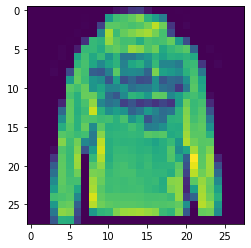

In [ ]:
plt.imshow(images[0].cpu().reshape(28, 28))

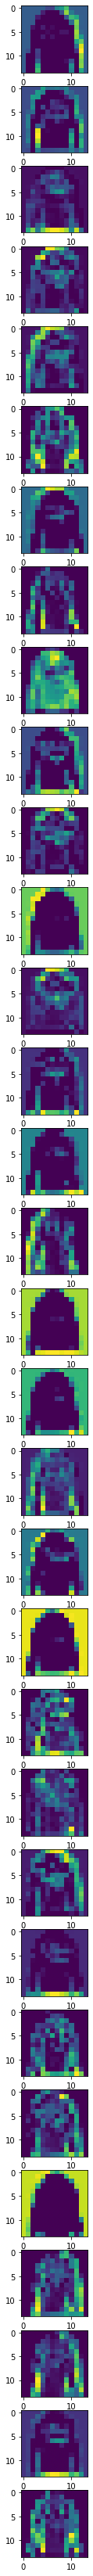

In [ ]:
fig, axs = plt.subplots(32, 1)
fig.set_figheight(60)
fig.set_figwidth(40)
with torch.no_grad():
  output = model.layer1(images[0].unsqueeze(0)).squeeze().cpu()
  for i in range(32):
    axs[i].imshow(output[i])

##  2. Классификация изображений (датасет CIFAR 10) 

#### Data Preprocessing

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                
                               ])

# Download and load the training data
trainset = datasets.CIFAR10('cfr10_data/', download = True, train = True, transform = transform)
testset = datasets.CIFAR10('cfr10_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = testset.__len__(), shuffle = True, pin_memory = True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cfr10_data/cifar-10-python.tar.gz to cfr10_data/
Files already downloaded and verified



### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

#### Model + Training

In [ ]:
model = nn.Sequential(nn.LazyLinear(256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.LazyLinear(128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.LazyLinear(64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.LazyLinear(10),
                      nn.LogSoftmax(dim = 1)
                     ).to(device)

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 1e-3)

epochs = 30

train_losses, test_losses = [], []

for e in tqdm.tqdm(range(epochs)):
  running_loss = 0
  model.train()
  for images, labels in trainloader:
    images = images.view(images.shape[0], -1).to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    
  with torch.no_grad():
      model.eval()
      
      for images, labels in testloader:
        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 1/30 [00:08<04:15,  8.82s/it]

Training loss: 1.993.. Test loss: 1.811.. Test Accuracy: 0.336


  7%|▋         | 2/30 [00:17<03:56,  8.46s/it]

Training loss: 1.839.. Test loss: 1.703.. Test Accuracy: 0.388


 10%|█         | 3/30 [00:25<03:46,  8.38s/it]

Training loss: 1.786.. Test loss: 1.681.. Test Accuracy: 0.391


 13%|█▎        | 4/30 [00:33<03:38,  8.42s/it]

Training loss: 1.752.. Test loss: 1.668.. Test Accuracy: 0.410


 17%|█▋        | 5/30 [00:42<03:28,  8.35s/it]

Training loss: 1.724.. Test loss: 1.608.. Test Accuracy: 0.420


 20%|██        | 6/30 [00:50<03:19,  8.31s/it]

Training loss: 1.707.. Test loss: 1.609.. Test Accuracy: 0.431


 23%|██▎       | 7/30 [00:58<03:11,  8.31s/it]

Training loss: 1.681.. Test loss: 1.606.. Test Accuracy: 0.424


 27%|██▋       | 8/30 [01:10<03:25,  9.36s/it]

Training loss: 1.672.. Test loss: 1.583.. Test Accuracy: 0.436


 30%|███       | 9/30 [01:18<03:09,  9.01s/it]

Training loss: 1.660.. Test loss: 1.583.. Test Accuracy: 0.441


 33%|███▎      | 10/30 [01:26<02:56,  8.81s/it]

Training loss: 1.648.. Test loss: 1.556.. Test Accuracy: 0.440


 37%|███▋      | 11/30 [01:35<02:44,  8.68s/it]

Training loss: 1.643.. Test loss: 1.570.. Test Accuracy: 0.433


 40%|████      | 12/30 [01:43<02:33,  8.52s/it]

Training loss: 1.637.. Test loss: 1.558.. Test Accuracy: 0.448


 43%|████▎     | 13/30 [01:51<02:23,  8.44s/it]

Training loss: 1.631.. Test loss: 1.556.. Test Accuracy: 0.440


 47%|████▋     | 14/30 [01:59<02:14,  8.42s/it]

Training loss: 1.624.. Test loss: 1.531.. Test Accuracy: 0.452


 50%|█████     | 15/30 [02:08<02:05,  8.40s/it]

Training loss: 1.617.. Test loss: 1.547.. Test Accuracy: 0.441


 53%|█████▎    | 16/30 [02:16<01:57,  8.38s/it]

Training loss: 1.612.. Test loss: 1.529.. Test Accuracy: 0.456


 57%|█████▋    | 17/30 [02:25<01:51,  8.58s/it]

Training loss: 1.602.. Test loss: 1.531.. Test Accuracy: 0.453


 60%|██████    | 18/30 [02:34<01:43,  8.61s/it]

Training loss: 1.602.. Test loss: 1.528.. Test Accuracy: 0.452


 63%|██████▎   | 19/30 [02:42<01:34,  8.55s/it]

Training loss: 1.594.. Test loss: 1.540.. Test Accuracy: 0.456


 67%|██████▋   | 20/30 [02:51<01:24,  8.48s/it]

Training loss: 1.586.. Test loss: 1.531.. Test Accuracy: 0.447


 70%|███████   | 21/30 [02:59<01:16,  8.46s/it]

Training loss: 1.585.. Test loss: 1.520.. Test Accuracy: 0.458


 73%|███████▎  | 22/30 [03:07<01:07,  8.39s/it]

Training loss: 1.576.. Test loss: 1.533.. Test Accuracy: 0.460


 77%|███████▋  | 23/30 [03:15<00:58,  8.35s/it]

Training loss: 1.578.. Test loss: 1.502.. Test Accuracy: 0.470


 80%|████████  | 24/30 [03:24<00:49,  8.33s/it]

Training loss: 1.570.. Test loss: 1.490.. Test Accuracy: 0.473


 83%|████████▎ | 25/30 [03:32<00:41,  8.31s/it]

Training loss: 1.568.. Test loss: 1.498.. Test Accuracy: 0.466


 87%|████████▋ | 26/30 [03:40<00:33,  8.30s/it]

Training loss: 1.564.. Test loss: 1.495.. Test Accuracy: 0.469


 90%|█████████ | 27/30 [03:49<00:24,  8.30s/it]

Training loss: 1.561.. Test loss: 1.499.. Test Accuracy: 0.461


 93%|█████████▎| 28/30 [03:57<00:16,  8.39s/it]

Training loss: 1.562.. Test loss: 1.513.. Test Accuracy: 0.460


 97%|█████████▋| 29/30 [04:06<00:08,  8.39s/it]

Training loss: 1.554.. Test loss: 1.504.. Test Accuracy: 0.464


100%|██████████| 30/30 [04:14<00:00,  8.48s/it]

Training loss: 1.553.. Test loss: 1.497.. Test Accuracy: 0.465


#### Loss history

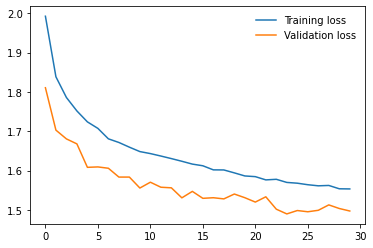

In [ ]:
plt.plot(train_losses, label = "Training loss")
plt.plot(list(map(lambda x: x.cpu(), test_losses)), label = "Validation loss")
plt.legend(frameon = False)

#### Eval + classification report

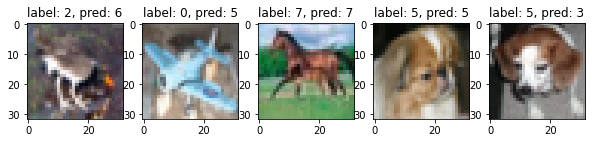

In [ ]:
fig, axs = plt.subplots(1, 5)
fig.set_figheight(5)
fig.set_figwidth(10)
with torch.no_grad():
  for i in range(5):
    image = images[i].reshape(3, 32, 32).cpu()
    label = labels[i].cpu()
    pred = torch.argmax(torch.exp(model(images[i].view(1, -1)))).cpu()
    axs[i].imshow(transforms.ToPILImage()(image))
    axs[i].set_title(f'label: {label}, pred: {pred}')

In [ ]:
for images, labels in testloader:
  output = model(images.view(images.shape[0], -1).to(device))
  output = torch.argmax(torch.exp(output), dim = 1).cpu().numpy()
  labels = labels.numpy()
print(classification_report(labels, output))

              precision    recall  f1-score   support

           0       0.43      0.56      0.48      1000
           1       0.56      0.48      0.52      1000
           2       0.30      0.30      0.30      1000
           3       0.34      0.14      0.20      1000
           4       0.37      0.27      0.31      1000
           5       0.36      0.39      0.37      1000
           6       0.39      0.59      0.47      1000
           7       0.41      0.59      0.49      1000
           8       0.55      0.50      0.53      1000
           9       0.53      0.43      0.47      1000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.41     10000
weighted avg       0.42      0.42      0.41     10000



### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

#### Model

In [ ]:
class NetCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=3136, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

#### Training

In [ ]:
model = NetCNN().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 5
train_losses, test_losses = [], []

for e in tqdm.tqdm(range(epochs)):
  
  running_loss = 0
  for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
      model.eval()
      
      for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

 20%|██        | 1/5 [00:10<00:42, 10.59s/it]

Training loss: 1.385.. Test loss: 1.294.. Test Accuracy: 0.537


 40%|████      | 2/5 [00:20<00:31, 10.35s/it]

Training loss: 1.036.. Test loss: 1.175.. Test Accuracy: 0.607


 60%|██████    | 3/5 [00:31<00:20, 10.37s/it]

Training loss: 0.932.. Test loss: 1.028.. Test Accuracy: 0.637


 80%|████████  | 4/5 [00:41<00:10, 10.27s/it]

Training loss: 0.856.. Test loss: 1.029.. Test Accuracy: 0.647


100%|██████████| 5/5 [00:51<00:00, 10.30s/it]

Training loss: 0.789.. Test loss: 0.928.. Test Accuracy: 0.685


#### First layer's result

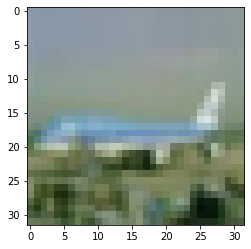

In [ ]:
plt.imshow(transforms.ToPILImage()(images[2].cpu().reshape(3, 32, 32)))

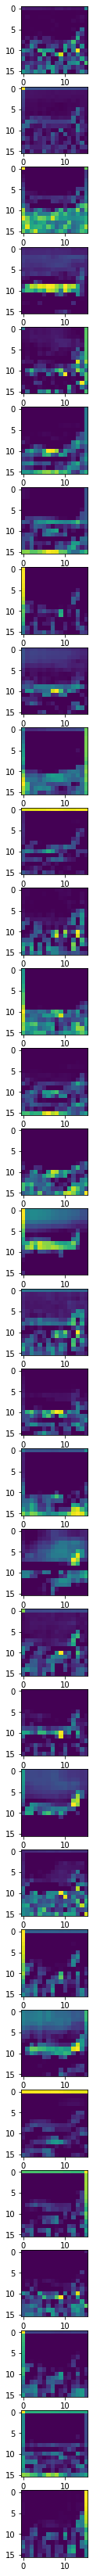

In [ ]:
fig, axs = plt.subplots(32, 1)
fig.set_figheight(60)
fig.set_figwidth(40)
with torch.no_grad():
  output = model.layer1(images[2].unsqueeze(0)).squeeze().cpu()
  for i in range(32):
    axs[i].imshow(output[i])

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 2767/2767 [00:21<00:00, 130.18it/s]


#### data preproccessing

In [ ]:
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Resize([400, 400]), 
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5,0.5,0.5])
    ])

dataset = ImageFolder(root = "/content/training/training", transform = transform)
train_size = int(dataset.__len__()*0.8)
val_size = dataset.__len__() - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = ImageFolder(root = "/content/training/training", transform = transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, pin_memory = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, pin_memory = True)

#### model

In [ ]:
class NetCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=313632, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

#### Training

In [ ]:
torch.cuda.empty_cache()
model = NetCNN().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 30
train_losses, test_losses = [], []

for e in tqdm(range(epochs)):
  model.train()
  running_loss = 0
  for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
  with torch.no_grad():
      model.eval()
      
      for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(valloader))
    
      print("Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(valloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))
      

  3%|▎         | 1/30 [00:51<24:46, 51.25s/it]

Training loss: 175.891.. Test loss: 57.367.. Test Accuracy: 0.295


  7%|▋         | 2/30 [01:33<21:24, 45.89s/it]

Training loss: 34.444.. Test loss: 24.064.. Test Accuracy: 0.427


 10%|█         | 3/30 [02:15<19:46, 43.95s/it]

Training loss: 15.719.. Test loss: 20.679.. Test Accuracy: 0.505


 13%|█▎        | 4/30 [02:57<18:44, 43.25s/it]

Training loss: 8.007.. Test loss: 13.230.. Test Accuracy: 0.577


 17%|█▋        | 5/30 [03:39<17:52, 42.92s/it]

Training loss: 8.373.. Test loss: 18.455.. Test Accuracy: 0.527


 20%|██        | 6/30 [04:21<17:00, 42.51s/it]

Training loss: 4.240.. Test loss: 12.082.. Test Accuracy: 0.605


 23%|██▎       | 7/30 [05:02<16:09, 42.16s/it]

Training loss: 2.845.. Test loss: 16.767.. Test Accuracy: 0.523


 27%|██▋       | 8/30 [05:44<15:27, 42.14s/it]

Training loss: 2.700.. Test loss: 16.988.. Test Accuracy: 0.541


 30%|███       | 9/30 [06:26<14:41, 41.97s/it]

Training loss: 1.112.. Test loss: 11.691.. Test Accuracy: 0.564


 33%|███▎      | 10/30 [07:07<13:55, 41.77s/it]

Training loss: 0.278.. Test loss: 10.998.. Test Accuracy: 0.600


 37%|███▋      | 11/30 [07:48<13:10, 41.61s/it]

Training loss: 0.197.. Test loss: 10.263.. Test Accuracy: 0.614


 40%|████      | 12/30 [08:31<12:33, 41.88s/it]

Training loss: 0.124.. Test loss: 10.029.. Test Accuracy: 0.600


 43%|████▎     | 13/30 [09:12<11:49, 41.75s/it]

Training loss: 0.179.. Test loss: 10.521.. Test Accuracy: 0.614


 47%|████▋     | 14/30 [09:54<11:07, 41.71s/it]

Training loss: 0.066.. Test loss: 10.534.. Test Accuracy: 0.614


 50%|█████     | 15/30 [10:35<10:24, 41.60s/it]

Training loss: 0.044.. Test loss: 10.511.. Test Accuracy: 0.618


 53%|█████▎    | 16/30 [11:18<09:47, 41.95s/it]

Training loss: 0.060.. Test loss: 10.632.. Test Accuracy: 0.623


 57%|█████▋    | 17/30 [12:00<09:03, 41.83s/it]

Training loss: 0.059.. Test loss: 10.698.. Test Accuracy: 0.618


 60%|██████    | 18/30 [12:41<08:20, 41.71s/it]

Training loss: 0.030.. Test loss: 10.503.. Test Accuracy: 0.623


 63%|██████▎   | 19/30 [13:22<07:37, 41.61s/it]

Training loss: 0.061.. Test loss: 10.595.. Test Accuracy: 0.623


 67%|██████▋   | 20/30 [14:05<06:58, 41.86s/it]

Training loss: 0.105.. Test loss: 10.427.. Test Accuracy: 0.618


 70%|███████   | 21/30 [14:46<06:14, 41.65s/it]

Training loss: 0.059.. Test loss: 10.447.. Test Accuracy: 0.618


 73%|███████▎  | 22/30 [15:28<05:32, 41.61s/it]

Training loss: 0.109.. Test loss: 10.448.. Test Accuracy: 0.614


 77%|███████▋  | 23/30 [16:10<04:52, 41.83s/it]

Training loss: 0.086.. Test loss: 10.593.. Test Accuracy: 0.618


 80%|████████  | 24/30 [16:51<04:10, 41.72s/it]

Training loss: 0.095.. Test loss: 10.793.. Test Accuracy: 0.623


 83%|████████▎ | 25/30 [17:32<03:27, 41.51s/it]

Training loss: 0.025.. Test loss: 10.763.. Test Accuracy: 0.623


 87%|████████▋ | 26/30 [18:14<02:45, 41.49s/it]

Training loss: 0.075.. Test loss: 10.558.. Test Accuracy: 0.614


 90%|█████████ | 27/30 [18:57<02:05, 41.83s/it]

Training loss: 0.059.. Test loss: 10.533.. Test Accuracy: 0.618


 93%|█████████▎| 28/30 [19:38<01:23, 41.72s/it]

Training loss: 0.082.. Test loss: 10.431.. Test Accuracy: 0.618


 97%|█████████▋| 29/30 [20:19<00:41, 41.66s/it]

Training loss: 0.092.. Test loss: 10.487.. Test Accuracy: 0.614


100%|██████████| 30/30 [21:01<00:00, 42.05s/it]

Training loss: 0.073.. Test loss: 10.776.. Test Accuracy: 0.614


#### Save model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/31.pth')

#### classification report

In [ ]:
preds = []
labels = []
with torch.no_grad():
  model.eval()
  for image, label in valloader:
    pred = torch.argmax(torch.exp(model(image.cuda())))
    preds.append(pred.item())
    labels.append(label.item())

In [ ]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.64      0.67      0.65        21
           1       0.38      0.67      0.48        18
           2       0.76      0.84      0.80        19
           3       0.70      0.70      0.70        33
           4       0.62      0.45      0.53        22
           5       0.59      0.48      0.53        21
           6       0.61      0.50      0.55        22
           7       0.75      0.44      0.56        27
           8       0.58      0.69      0.63        16
           9       0.62      0.76      0.68        21

    accuracy                           0.61       220
   macro avg       0.62      0.62      0.61       220
weighted avg       0.63      0.61      0.61       220



#### eval

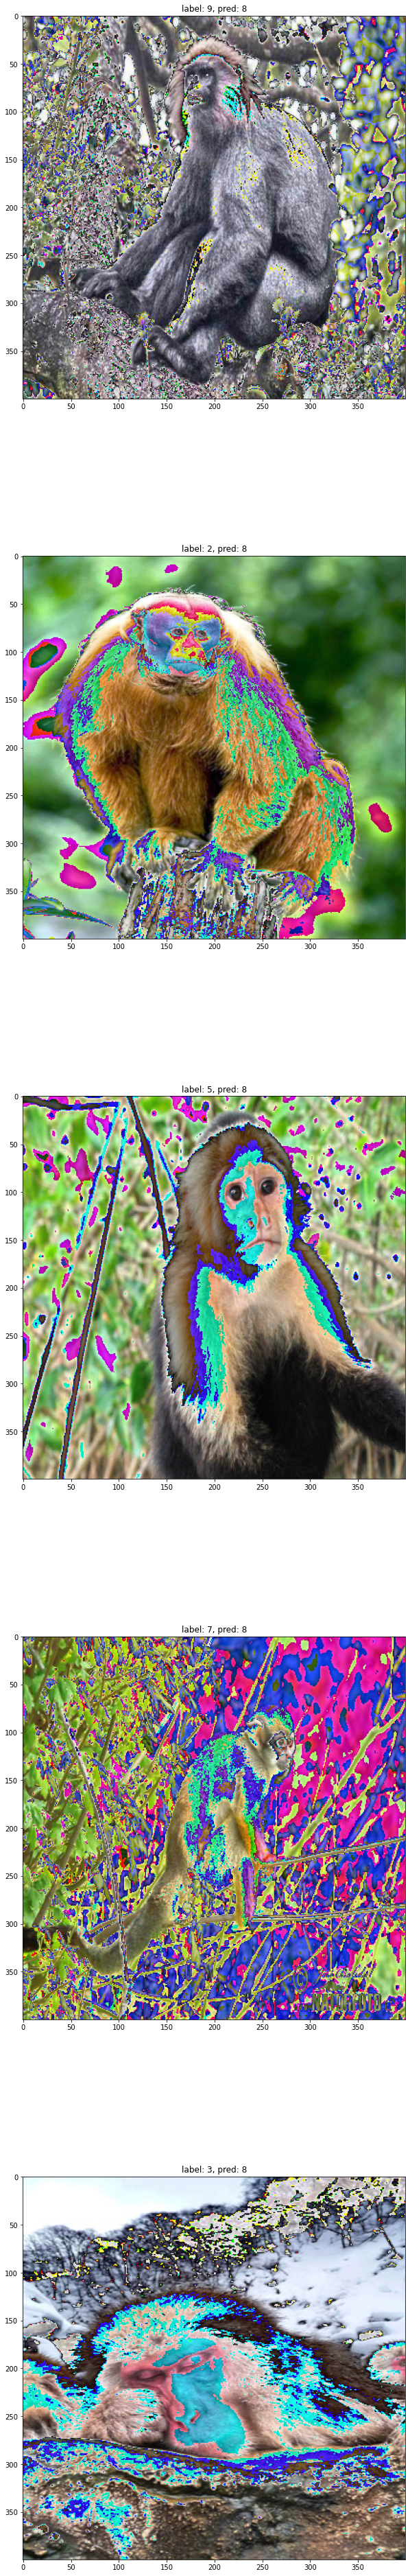

In [ ]:
fig, axs = plt.subplots(5, 1)
fig.set_figheight(70)
fig.set_figwidth(10)
with torch.no_grad():
  model.eval()
  for i in range(5):
    image, label = val_dataset.__getitem__(i)
    pred = torch.argmax(torch.exp(model(images))).cpu()
    axs[i].imshow(transforms.ToPILImage()(image))
    axs[i].set_title(f'label: {label}, pred: {pred}')

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 25004/25004 [00:10<00:00, 2301.08it/s]


#### Data Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize([400, 400]), 
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5,0.5,0.5])
    ])

dataset = ImageFolder(root = "/content/cats_dogs/train", transform = transform)
train_size = int(dataset.__len__()*0.8)
val_size = dataset.__len__() - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, pin_memory = True)

#### Model

In [ ]:
class NetCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=313632, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

#### Trainig

In [ ]:
torch.cuda.empty_cache()
model = NetCNN().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 10
train_losses, test_losses = [], []

for e in tqdm(range(epochs)):
  model.train()
  running_loss = 0
  for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
  with torch.no_grad():
      model.eval()
      
      for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(valloader))
    
      print("Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(valloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))
      if len(test_losses) > 3:
        if test_losses[-1] > test_losses[-2] and test_losses[-1] > test_losses[-3]:
          optimizer.param_groups[0]['lr'] *= 0.1

      if accuracy/len(valloader) >= 0.8:
        break

 10%|█         | 1/10 [06:20<57:05, 380.62s/it]

Training loss: 3.135.. Test loss: 0.710.. Test Accuracy: 0.672


 20%|██        | 2/10 [12:41<50:48, 381.03s/it]

Training loss: 0.745.. Test loss: 0.660.. Test Accuracy: 0.650


 30%|███       | 3/10 [19:01<44:21, 380.27s/it]

Training loss: 0.726.. Test loss: 0.587.. Test Accuracy: 0.683


 40%|████      | 4/10 [25:24<38:08, 381.42s/it]

Training loss: 0.684.. Test loss: 0.586.. Test Accuracy: 0.683


 50%|█████     | 5/10 [31:46<31:47, 381.57s/it]

Training loss: 0.632.. Test loss: 0.659.. Test Accuracy: 0.669


 60%|██████    | 6/10 [38:06<25:24, 381.10s/it]

Training loss: 0.465.. Test loss: 0.516.. Test Accuracy: 0.744


 70%|███████   | 7/10 [44:26<19:01, 380.59s/it]

Training loss: 0.444.. Test loss: 0.543.. Test Accuracy: 0.727


 80%|████████  | 8/10 [50:45<12:40, 380.38s/it]

Training loss: 0.421.. Test loss: 0.532.. Test Accuracy: 0.742


 90%|█████████ | 9/10 [57:06<06:20, 380.40s/it]

Training loss: 0.402.. Test loss: 0.560.. Test Accuracy: 0.737


100%|██████████| 10/10 [1:03:25<00:00, 380.57s/it]

Training loss: 0.337.. Test loss: 0.546.. Test Accuracy: 0.745


# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 2767/2767 [00:17<00:00, 161.37it/s]


#### Data Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize([224, 224]), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

dataset = ImageFolder(root = "/content/training/training", transform = transform)
train_size = int(dataset.__len__()*0.8)
val_size = dataset.__len__() - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = ImageFolder(root = "/content/training/training", transform = transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, pin_memory = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, pin_memory = True)

#### Pretrained model

In [ ]:
model = torchvision.models.vgg16(pretrained=True)
model = model.to(device)

In [ ]:
print(model._modules.keys())
print(model._modules['classifier'])

odict_keys(['features', 'avgpool', 'classifier'])
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
model.features.requires_grad = False
model.classifier.requires_grad = True
model.classifier[6].out_features = 10

#### Training

In [ ]:
torch.cuda.empty_cache()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.classifier[6].parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 5
train_losses, test_losses = [], []

for e in tqdm(range(epochs)):
  model.train()
  running_loss = 0
  for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
  with torch.no_grad():
      model.eval()
      
      for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(valloader))
    
      print("Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(valloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))
      if len(test_losses) > 3:
        if test_losses[-1] > test_losses[-2] and test_losses[-1] > test_losses[-3]:
          optimizer.param_groups[0]['lr'] *= 0.1

 20%|██        | 1/5 [00:49<03:16, 49.11s/it]

Training loss: 8.342.. Test loss: 0.459.. Test Accuracy: 0.882


 40%|████      | 2/5 [01:38<02:28, 49.43s/it]

Training loss: 0.273.. Test loss: 0.104.. Test Accuracy: 0.977


 40%|████      | 2/5 [01:43<02:35, 51.92s/it]


KeyboardInterrupt: ignored

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

#### Data Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize([224, 224]), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

dataset = ImageFolder(root = "/content/cats_dogs/train", transform = transform)
train_size = int(dataset.__len__()*0.8)
val_size = dataset.__len__() - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, pin_memory = True)

#### Pretr model

In [ ]:
model = torchvision.models.vgg16(pretrained=True)
model = model.to(device)

model.features.requires_grad = False
model.classifier.requires_grad = True
model.classifier[6].out_features = 2

#### Trainig

In [ ]:
torch.cuda.empty_cache()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.classifier[6].parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 5
train_losses, test_losses = [], []

for e in tqdm(range(epochs)):
  model.train()
  running_loss = 0
  for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
  with torch.no_grad():
      model.eval()
      
      for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(valloader))
    
      print("Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(valloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))
      if len(test_losses) > 3:
        if test_losses[-1] > test_losses[-2] and test_losses[-1] > test_losses[-3]:
          optimizer.param_groups[0]['lr'] *= 0.1
      if accuracy/len(valloader) >= 0.96:
        break

  0%|          | 0/5 [08:52<?, ?it/s]

Training loss: 0.249.. Test loss: 0.037.. Test Accuracy: 0.986
